In [10]:
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch
import json
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import kagglehub

np.random.seed(42)
torch.manual_seed(42)

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [12]:
path = kagglehub.dataset_download("nagasai524/mini-coco2014-dataset-for-image-captioning")

with open(os.path.join(path, "captions.json"), "r") as f:
    data = json.load(f)
    annotations = data["annotations"] if isinstance(data, dict) else data

captions = {}
for item in annotations:
    img_id = item["image_id"]
    if img_id not in captions:
        captions[img_id] = []
    captions[img_id].append(item["caption"])

for root, dirs, files in os.walk(path):
    if any(f.endswith(".jpg") for f in files):
        img_folder = root
        break

img_ids = list(captions.keys())
print(f"Ready: {len(captions)} images loaded")

Resuming download from 1023410176 bytes (2017006921 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/nagasai524/mini-coco2014-dataset-for-image-captioning?dataset_version_number=1 (1023410176/3040417097) bytes left.


100%|██████████| 2.83G/2.83G [08:32<00:00, 3.94MB/s]

Extracting files...


Ready: 18783 images loaded


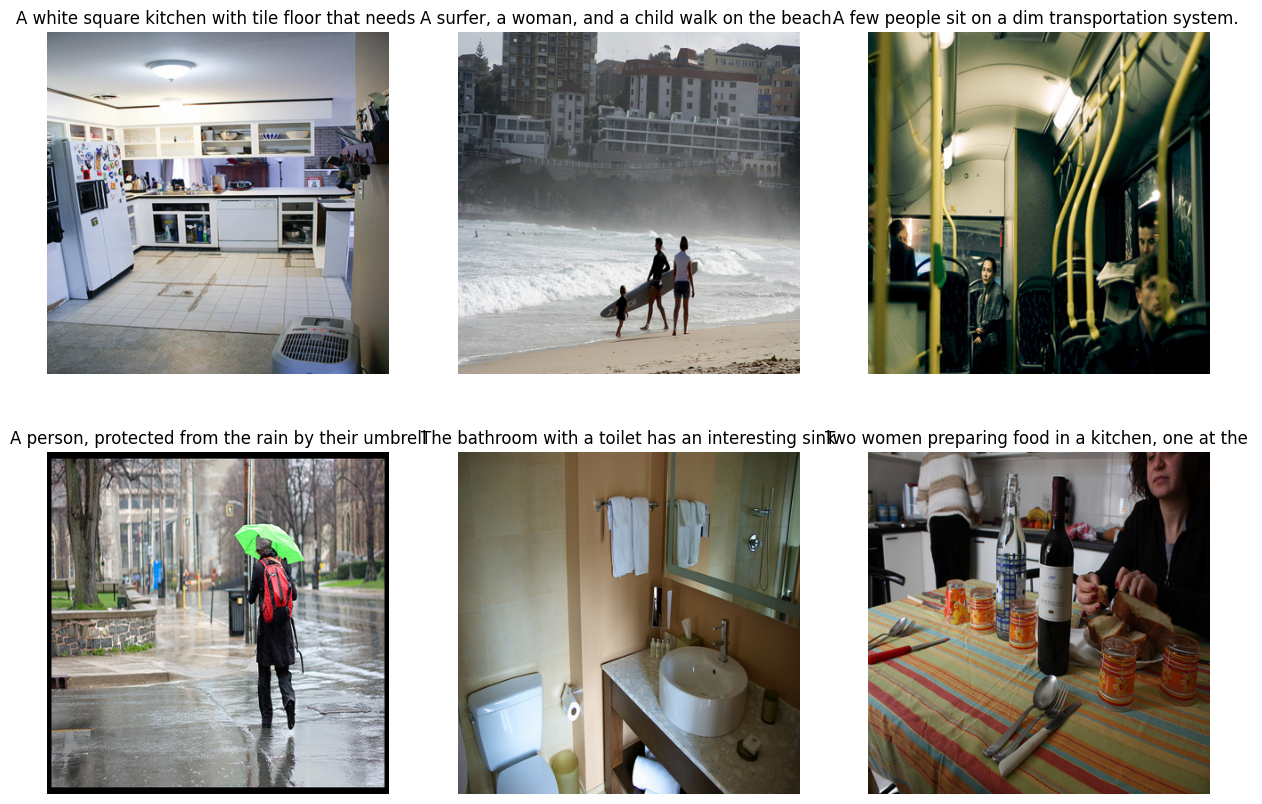

In [13]:
def get_image(idx):
    img_id = img_ids[idx]
    img_path = os.path.join(img_folder, f"COCO_train2014_{img_id:012d}.jpg")
    if not os.path.exists(img_path):
        img_path = os.path.join(img_folder, f"{img_id}.jpg")
    return Image.open(img_path).convert("RGB").resize((384, 384)), captions[img_id]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
    img, caps = get_image(i)
    ax.imshow(img)
    ax.set_title(f"{caps[0][:50]}")
    ax.axis("off")
plt.show()

In [14]:
selected = [0, 1, 2]

for idx in selected:
    img, caps = get_image(idx)
    print(f"Image {idx}: {caps[0]}")

Image 0: A white square kitchen with tile floor that needs repairs 
Image 1: A surfer, a woman, and a child walk on the beach.
Image 2: A few people sit on a dim transportation system. 


In [15]:
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.48145466, 0.4578275, 0.40821073], 
                        [0.26862954, 0.26130258, 0.27577711])
])

def to_tensor(idx):
    img, _ = get_image(idx)
    return normalize(img).unsqueeze(0).to(device)

test = to_tensor(0)
print(f"Tensor ready for BLIP: {test.shape}")

Tensor ready for BLIP: torch.Size([1, 3, 384, 384])


In [16]:
# Load BLIP model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to(device)
model.eval()
print("BLIP model loaded")

BLIP model loaded


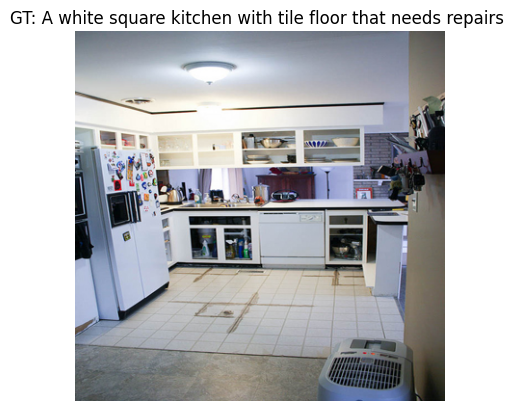

Image index: 0
Ground truth: A white square kitchen with tile floor that needs repairs 
BLIP caption: there is a kitchen with a refrigerator, stove, microwave and refrigerator


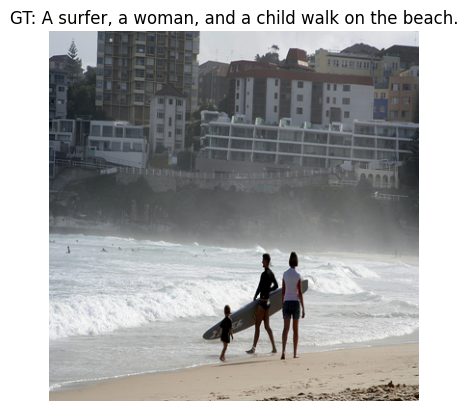

Image index: 1
Ground truth: A surfer, a woman, and a child walk on the beach.
BLIP caption: surfers walking on the beach with their surfboards in hand


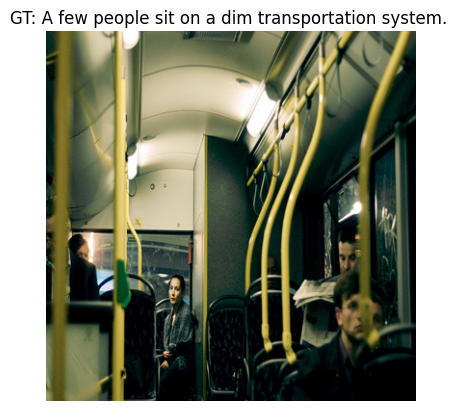

Image index: 2
Ground truth: A few people sit on a dim transportation system. 
BLIP caption: people sitting on a bus with their backs turned


In [17]:
def generate_blip_caption(idx, show_image=True):
    """Run BLIP on one COCO image and print GT and predicted captions."""
    # get PIL image (already resized to 384x384) and list of ground truth captions
    img, gt_caps = get_image(idx)

    if show_image:
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"GT: {gt_caps[0][:60]}")
        plt.show()

    # use the processor to prepare tensors for BLIP
    inputs = processor(img, return_tensors="pt").to(device)

    # generate caption without gradients
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=30,  # you can change the length later
        )

    # decode token ids back to text
    pred_caption = processor.decode(output_ids[0], skip_special_tokens=True)

    print(f"Image index: {idx}")
    print(f"Ground truth: {gt_caps[0]}")
    print(f"BLIP caption: {pred_caption}")

    return img, gt_caps, pred_caption

# quick test on a few selected images
for i in [0, 1, 2]:
    generate_blip_caption(i, show_image=True)

In [ ]:
def extract_blip_attention(idx):
    """Extract vision attention from BLIP model."""
    # Get image and ground truth
    img, gt_caps = get_image(idx)
    
    # Prepare for BLIP
    inputs = processor(img, return_tensors="pt").to(device)
    
    # Hook to capture vision attention
    vision_attentions = []
    
    def hook_fn(module, input, output):
        if len(output) > 1 and output[1] is not None:
            vision_attentions.append(output[1].detach())
    
    # Register hooks
    hooks = []
    for layer in model.vision_model.encoder.layers:
        hook = layer.self_attn.register_forward_hook(hook_fn)
        hooks.append(hook)
    
    # Generate caption and capture attention
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=30)
        pred_caption = processor.decode(outputs[0], skip_special_tokens=True)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    print(f"Caption: {pred_caption}")
    print(f"Captured {len(vision_attentions)} layers of attention")
    
    return img, gt_caps, pred_caption, vision_attentions

# Test
img, gt_caps, pred_caption, vision_attn = extract_blip_attention(0)

In [ ]:
def aggregate_sentence_based(vision_attentions, k_percent=0.5):
    """Baseline 1: Sentence-based (paper's main method)"""
    all_attention = []
    for layer_attn in vision_attentions:
        attn = layer_attn.mean(dim=1)  # Average heads
        cls_to_patches = attn[0, 0, 1:]  # CLS -> patches
        all_attention.append(cls_to_patches)
    
    aggregated = torch.stack(all_attention).mean(dim=0)  # [576]
    aggregated_2d = aggregated.reshape(24, 24)
    
    # Select top-k
    k = int(576 * k_percent)
    threshold = torch.topk(aggregated.flatten(), k).values.min()
    mask = (aggregated_2d >= threshold).float()
    
    return aggregated_2d.cpu().numpy(), mask.cpu().numpy()

# Test
agg_attn, mask = aggregate_sentence_based(vision_attn, k_percent=0.5)
print(f"Selected {int(mask.sum())} patches")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def visualize_attention_overlay(img, pred_caption, agg_attn, mask, method_name="Sentence-based"):
    """Better visualization with overlay on original image"""
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # 1. Original
    axes[0].imshow(img)
    axes[0].set_title(f"Original\n{pred_caption[:40]}")
    axes[0].axis('off')
    
    # 2. Heatmap overlay on image
    # Resize attention to match image size
    img_array = np.array(img.resize((384, 384)))  # BLIP uses 384x384
    attn_resized = np.array(Image.fromarray((agg_attn * 255).astype(np.uint8)).resize((384, 384)))
    attn_resized = attn_resized / 255.0
    
    axes[1].imshow(img_array)
    axes[1].imshow(attn_resized, cmap='hot', alpha=0.5)  # Overlay with transparency
    axes[1].set_title(f"{method_name}\nHeatmap Overlay")
    axes[1].axis('off')
    
    # 3. Attention heatmap alone (smooth)
    axes[2].imshow(agg_attn, cmap='hot', interpolation='bilinear')  # Smooth interpolation
    axes[2].set_title("Attention Heatmap\n(Smoothed)")
    axes[2].axis('off')
    
    # 4. Selected patches overlay
    mask_resized = np.array(Image.fromarray((mask * 255).astype(np.uint8)).resize((384, 384), Image.NEAREST))
    mask_resized = mask_resized / 255.0
    
    axes[3].imshow(img_array)
    axes[3].imshow(mask_resized, cmap='Reds', alpha=0.4)  # Red overlay for selected patches
    axes[3].set_title(f"Top 50% Patches\nSelected for Attack")
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Test improved visualization
visualize_attention_overlay(img, pred_caption, agg_attn, mask, "Sentence-based")